In [36]:
# !pip install plotly
# !pip install calmap
# !pip install cufflinks
# !pip install pycountry_convert 
# !pip install folium
# !pip install keras
# !pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

%matplotlib inline

In [38]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [39]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [40]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"

df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"

countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])

In [41]:
df_table = df_table[df_table["continent"] != "Others"]

In [42]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [43]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

In [44]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

In [45]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=float).transpose()
df_t["Mortality Rate (per 100)"] = 100*df_t["Deaths"]/df_t["Confirmed"]

In [46]:
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)

In [47]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)
world_map

mw = folium.Map(location=[10, 0], zoom_start=2,max_zoom=6,min_zoom=2)

In [48]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Confirmed"]),
                    hover_name="country", 
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

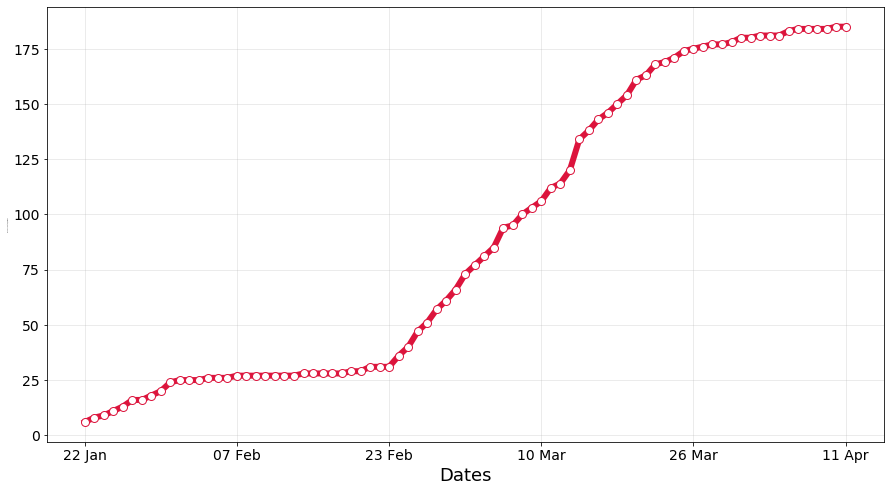

In [49]:
# number of countries affected over time
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

plt.savefig(out+'spread.png')
plt.show()
plt.close()

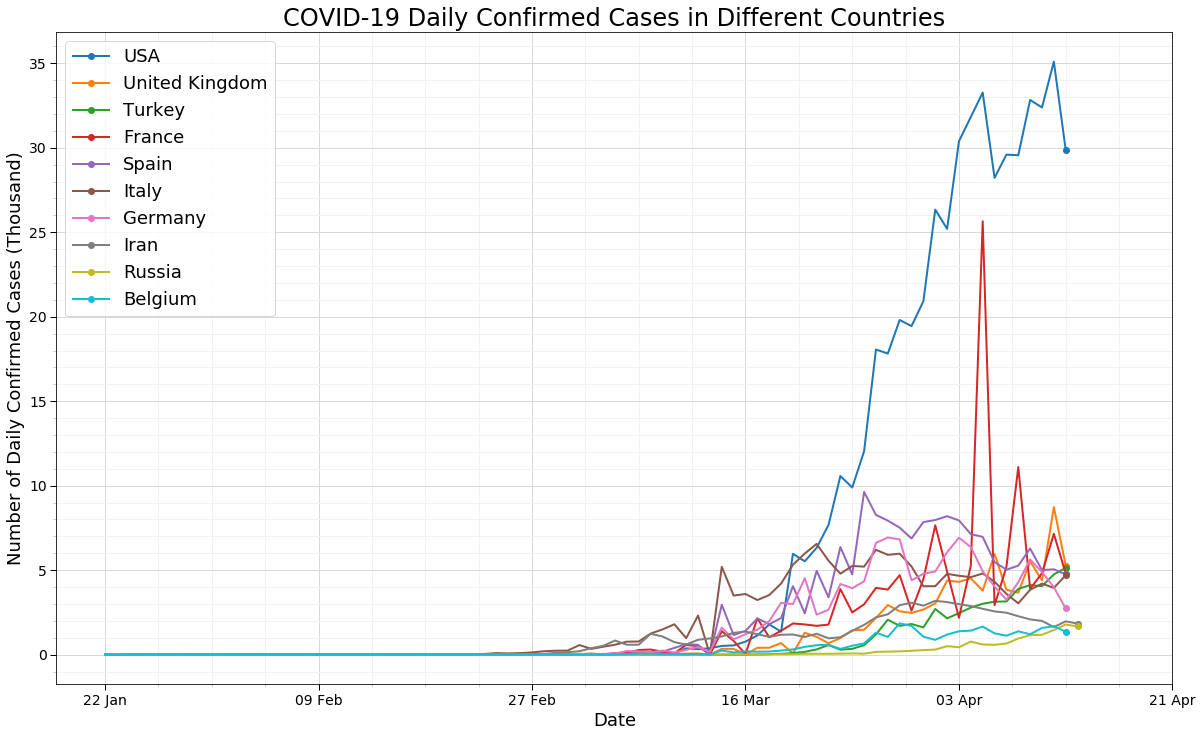

In [50]:
# daily new cases in different countries
thoudand = 1000
prediction_days = 10
temp = df_confirmed.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Confirmed Cases in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily confirmed cases countrywise.png")
plt.show()


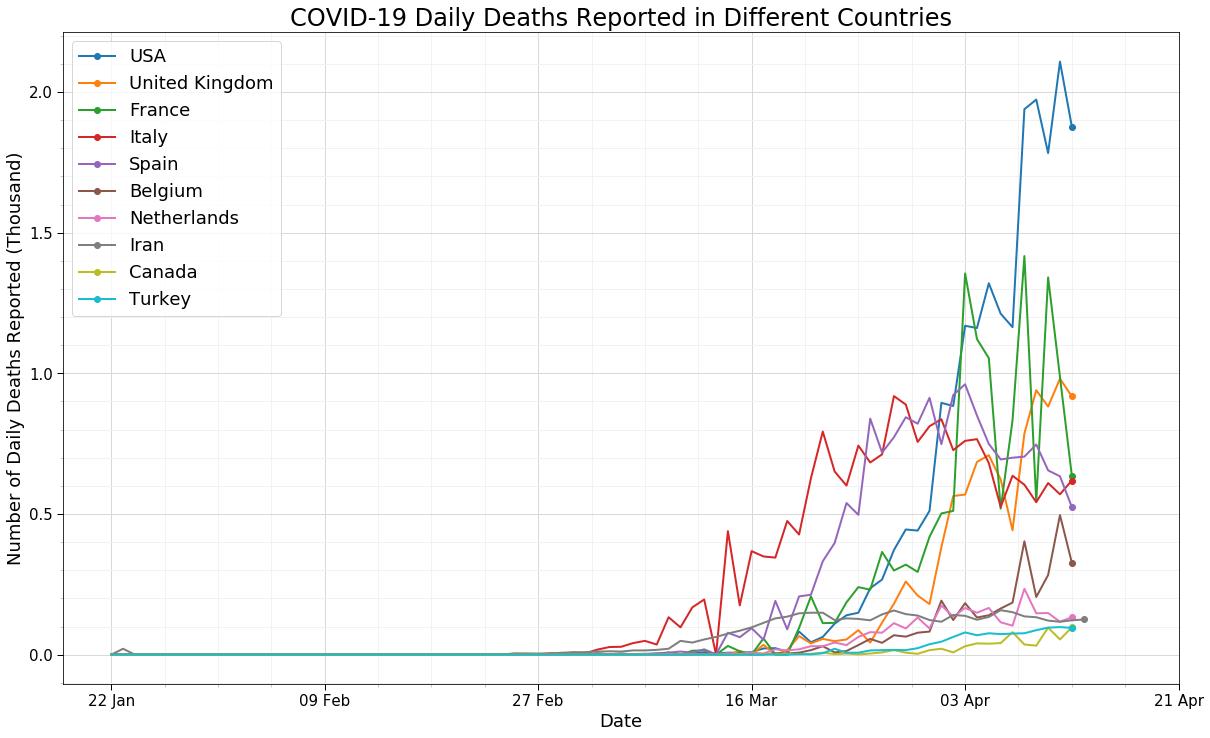

In [51]:
# daily death cases
thoudand = 1000
temp = df_deaths.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=15)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Deaths Reported in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily deaths reported countrywise.png")
plt.show()

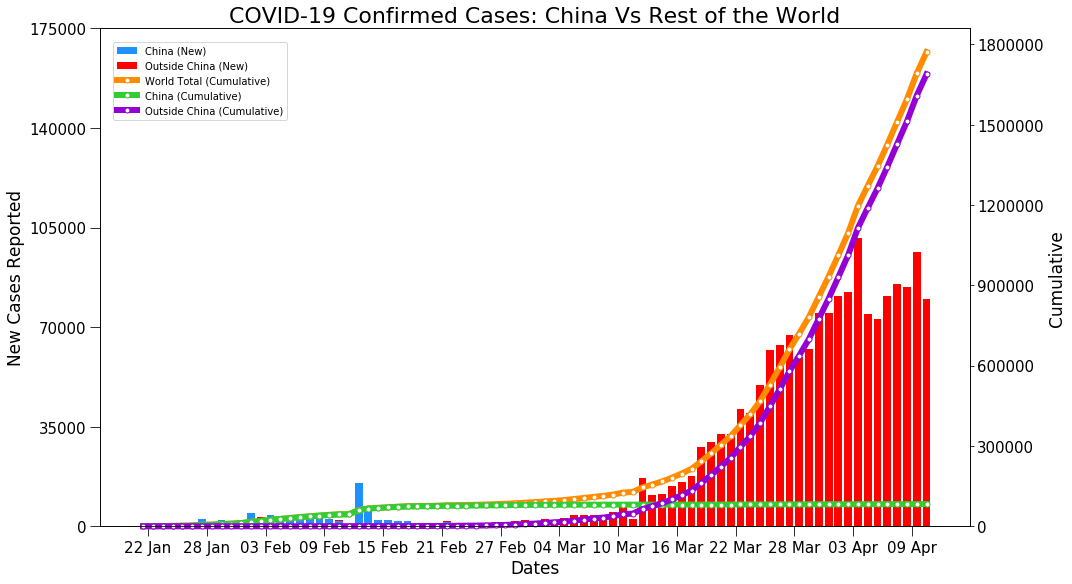

In [52]:
# China vs Outside China
df_confirmed_report = df_confirmed.copy()
df_confirmed_report.loc[df_confirmed_report['country'] != "China","country"] = "Outside China"
df_confirmed_report = df_confirmed_report.groupby("country").sum().drop(["Lat","Long"],axis =1)
df_confirmed_report.loc["Total"] = df_confirmed_report.sum()
df_confirmed_newcases = df_confirmed_report.groupby(level =0).diff(axis =1)
df_confirmed_newcases = df_confirmed_newcases.replace(np.nan, 0, regex=True) 
f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)

ax1.bar(df_confirmed_report[df_confirmed_report.index == "China"].columns,df_confirmed_newcases[df_confirmed_newcases.index == "China"].values[0], label = "China (New)",color='dodgerblue')
ax1.bar(df_confirmed_report[df_confirmed_report.index == "Outside China"].columns,df_confirmed_newcases[df_confirmed_newcases.index == "Outside China"].values[0],bottom=df_confirmed_newcases[df_confirmed_newcases.index == "China"].values[0],label = "Outside China (New)",color='red')

# Labels
ax1.set_xlabel("Dates",fontsize=17)
ax1.set_ylabel("New Cases Reported",fontsize =17)

ax1.tick_params(size=10,labelsize=15)
ax1.set_xticks(np.arange(0.5, len(df_confirmed_report.columns), 6))
ax1.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_report.columns][::6],fontsize=15)
l = np.arange(0, df_confirmed_report.max(axis = 1)[2]/10+10000, 5000)
ax1.set_yticks(l[::int(len(l)/5)])
# ax1.spines['bottom'].set_position('zero')

ax2 = ax1.twinx()
marker_style = dict(linewidth=6, linestyle='-', marker='.',markersize=10, markerfacecolor='#ffffff')

ax2.plot(df_confirmed_report[df_confirmed_report.index == "Total"].columns ,df_confirmed_report[df_confirmed_report.index == "Total"].values[0],**marker_style,label = "World Total (Cumulative)",color="darkorange",clip_on=False)
ax2.plot(df_confirmed_report[df_confirmed_report.index == "China"].columns ,df_confirmed_report[df_confirmed_report.index == "China"].values[0],**marker_style,label = "China (Cumulative)",color="limegreen",clip_on=False)
ax2.plot(df_confirmed_report[df_confirmed_report.index == "Outside China"].columns ,df_confirmed_report[df_confirmed_report.index == "Outside China"].values[0],**marker_style,label ="Outside China (Cumulative)",color="darkviolet",clip_on=False)
ax2.bar([0],[0])

ax2.tick_params(labelsize=15)
ax2.set_ylabel("Cumulative",fontsize =17)
ax2.set_xticks(np.arange(0.5, len(df_confirmed_report.columns), 6))
ax2.set_xticklabels([datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_confirmed_report.columns][::6])
l = np.arange(0, df_confirmed_report.max(axis = 1)[2]+100000, 100000)
ax2.set_yticks(l[::int(len(l)/5)])

f.tight_layout()
f.legend(loc = "upper left", bbox_to_anchor=(0.1,0.95))
plt.title("COVID-19 Confirmed Cases: China Vs Rest of the World",fontsize = 22)
plt.savefig(out+'China vs Rest of the world.png')
plt.show()

In [53]:
# USA
date_usa = datetime.strptime(df_confirmed.columns[-1],'%m/%d/%y').strftime("%m-%d-%Y")
df_temp = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date_usa+".csv")
df_usa = df_temp.loc[df_temp["Country_Region"]== "US"]
df_usa = df_usa.rename(columns={"Admin2":"County"})

total = df_usa.sum()
total.name = "Total"
pd.DataFrame(total).transpose().loc[:,["Confirmed","Deaths"]].style.background_gradient(cmap='Purples',axis=1)

df_usa = df_usa.replace(np.nan, 0, regex=True)
usa = folium.Map(location=[37, -102], zoom_start=4,max_zoom=8,min_zoom=4)
for i in np.int32(np.asarray(df_usa[df_usa['Confirmed'] > 0].index)):
    folium.Circle(
        location=[df_usa.loc[i]['Lat'], df_usa.loc[i]['Long_']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_usa.loc[i]['Province_State']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_usa.loc[i]['County']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_usa.loc[i]['Confirmed'])+"</li>"+
        "<li>Active:   "+str(df_usa.loc[i]['Active'])+"</li>"+
        "<li>Recovered:   "+str(df_usa.loc[i]['Recovered'])+"</li>"+       
        "<li>Deaths:   "+str(df_usa.loc[i]['Deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_usa.loc[i]['Deaths']/(df_usa.loc[i]['Confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=int((np.log2(df_usa.loc[i]['Confirmed']+1))*6000),
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(usa)

usa

In [54]:
state_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json').json()
county_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us_counties_20m_topo.json').json()

data_temp = df_usa.groupby(["Province_State"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_temp["Confirmed_log"] = np.log10(data_temp["Confirmed"]+1)
bins = list(data_temp['Confirmed_log'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=6,min_zoom=3)
 
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data = data_temp,
    columns=['Province_State', 'Confirmed_log'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = bins,
    reset=True,
    legend_name='Confirmed cases log (10^x)'
).add_to(m)
folium.LayerControl().add_to(m)

legend_html = "<div style='padding:10px;background-color:rgba(255,255,255,0.5);position:fixed;bottom:20px;left:20px;z-index:1000'>"
legend_html += "<div style='width:100%;text-align:center;'><h4>Index for Legend</h4></div><hr style='border-top-color: rgba(25,25,25,0.5);'>"
legend_html += "<ul style='margin:0;padding:0;color: #555;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"
for i in bins:
    legend_html += "<li style='margin:0;padding:0;line-height: 0;'>Value "+str(np.round(i,2))+" : "+str(int(10**i)-1)+"</li><br>"
legend_html += "</ul></div>"
m.get_root().html.add_child(folium.Element(legend_html))
m


In [55]:
data_temp = df_usa.groupby(["FIPS"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_temp["Confirmed_log"] = np.log10(data_temp["Confirmed"]+1)

df_usa_series = data_temp.set_index('FIPS')['Confirmed_log']
colorscale = branca.colormap.linear.Reds_09.scale(0,data_temp["Confirmed_log"].max()-1)
# print(df_usa_series.max())
def style_function(feature):
    employed = df_usa_series.get(int(feature['id'][-5:]), 0)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }


m = folium.Map(
    location=[37, -102],
    tiles='cartodbpositron',
    zoom_start=4,
    min_zoom=3,
    max_zoom=7
)

folium.TopoJson(
    county_geo,
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)
m

In [56]:
# Test data analysis
df_test = pd.read_csv("https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/v53/test.csv")[:-1]
df_test["country"] = [ c.split(" ")[0] for c in df_test["Entity"].values]
df_test.loc[17,"country"] ="USA"
df_test.loc[16,"country"] = "United Kingdom"
df_test.loc[15,"country"] = "South Korea"

df_test = df_test.loc[:,["country","Cumulative total","Cumulative total per million"]]

In [57]:
df_test["confirmed"] = [ df_countries_cases.loc[c,'Confirmed'] for c in df_test["country"].values]
df_test["deaths"] = [ df_countries_cases.loc[c,'Deaths'] for c in df_test["country"].values]
df_test["MR"] = np.round(100*df_test["deaths"]/df_test["confirmed"],2)
df_test["Positive"] = np.round(100*df_test["confirmed"]/df_test["Cumulative total"],2)
df_test.style.background_gradient(cmap='Blues',subset=["Cumulative total"])\
                        .background_gradient(cmap='Reds',subset=["Cumulative total per million"])\
                        .background_gradient(cmap='Greens',subset=["confirmed"])\
                        .background_gradient(cmap='Purples',subset=["deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["MR"])\
                        .background_gradient(cmap='bone_r',subset=["Positive"])

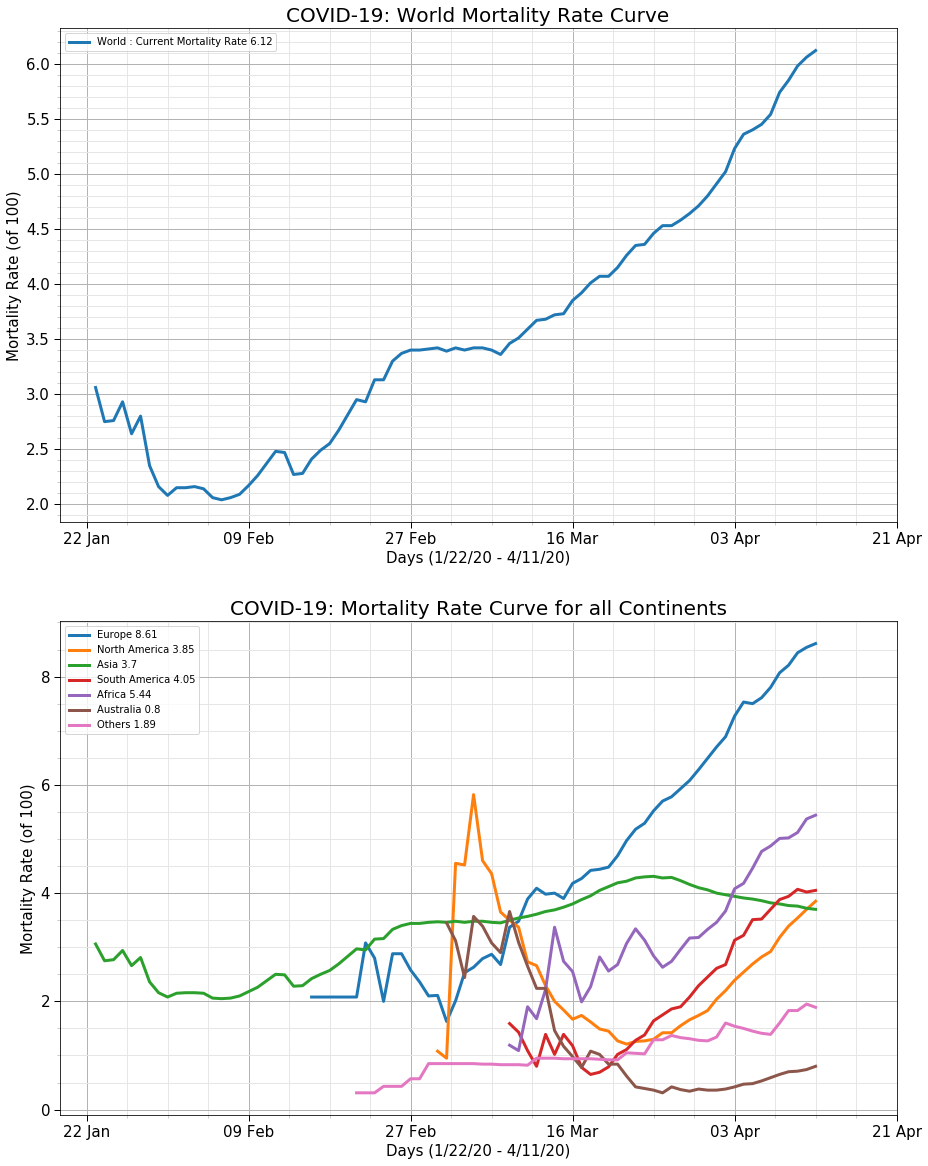

In [58]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index
continents = ["All"]+list(continents)

cols =1
rows = 2
axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","Mortality Rate (of 100)"]

f = plt.figure(figsize=(15,10*rows))

#SubPlot 1
ax = f.add_subplot(211)
mortality_rate = get_mortality_rate(df_confirmed,df_deaths,continent=continents[0])
plt.plot(np.arange(1,mortality_rate.shape[0]+1),mortality_rate,label = "World : Current Mortality Rate "+str(mortality_rate[-1]),linewidth=3)

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])
plt_title = "COVID-19: World Mortality Rate Curve"
plot_params(ax,axis_label,plt_title)
# Legend Location
l = plt.legend(loc= "best")


#SubPlot 2
ax = f.add_subplot(212)
for i, continent in enumerate(continents[1:]):
    mortality_rate = get_mortality_rate(df_confirmed,df_deaths,continent=continent)
#     mortality_rate = mortality_rate.replace(np.nan, 0, regex=True)
    plt.plot(np.arange(1+mortality_rate[mortality_rate == 0].shape[0],mortality_rate[mortality_rate == 0].shape[0]+mortality_rate[mortality_rate > 0].shape[0]+1),mortality_rate[mortality_rate > 0],label = continents[i+1]+" "+str(mortality_rate[-1]),linewidth=3)
# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])
    
plt_title = "COVID-19: Mortality Rate Curve for all Continents"
plot_params(ax,axis_label,plt_title)

# Legend Location
l = plt.legend(loc= "best")

plt.minorticks_on()
plt.savefig(out+'Mortality rate.png')
plt.show()